# Hacker News Trends
---

This tool will allow users to search for a specific keyword on Hacker News, a social news site that focuses on computer science and entrepreneurship, and see how popular that keyword has been over a period of time.

I'm planning to expand this to other social media sites like Twitter or Reddit and create an interactive web app in the future. Hacker News is a good starting point because it has a more manageable amount of data and a simpler API to work with.

---
# Showroom

In [ ]:
hn_keyword()

<div>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
    <br>
</div>

---
# Here's the code:

In [2]:
import requests
import pandas as pd
import json
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def hn_keyword():
    keyword = input('What trend do you want to see? ')
    
    # Obtain data
    response = requests.get(f'http://hn.algolia.com/api/v1/search?query={keyword}&tags=story')
    data = response.json()
    num_hits = data['nbHits']
    
    if data['nbHits'] == 0:
        print(f"Sorry, there are no stories about '{keyword}' on Hacker News. Try again.")
        return
    
    print(f"There are {num_hits} stories posted on Hacker News for '{keyword}'. \n")
    
    response = requests.get(f'http://hn.algolia.com/api/v1/search?query={keyword}&tags=story&hitsPerPage={num_hits}')
    data = response.json()
    
    most_points = 0
    story_title = None
    story_url = None
    for hit in data['hits']:
        if hit['points'] >= most_points:
            most_points = hit['points']
            story_title = hit['title']
            story_url = hit['url']

    print(f"The most popular story is '{story_title}' with {most_points} points.")
    print(f"You can read it here: {story_url}")
    
    # Clean and sort data
    
    # Grab what we need (title and time)
    title = []
    unix_time = []

    for d in data['hits']:
        title.append(d['title'])
        unix_time.append(d['created_at_i'])
        
    prep_data = {'title': title,
          'unix_time': unix_time}

    # Create the panda dataframe
    df = pd.DataFrame(prep_data)
    
    # Unix to human time
    df['date_time'] = pd.to_datetime(df['unix_time'],unit='s')
    
    # Sort by chronological order
    df = df.sort_values(by=['unix_time'])
    df = df.reset_index(drop=True)
    
    # Group by month
    grouped_data = df.groupby([df['date_time'].dt.year.rename('year'), 
                               df['date_time'].dt.month.rename('month')]).count()
    
    # Add grouped year/month from index to dataframe
    grouped_data.reset_index(inplace=True)
    
    # Combine year/month columns into usable data
    grouped_data['date_clean'] = pd.to_datetime(grouped_data[['year','month']].assign(DAY=1))
    grouped_data['pl_date'] = md.date2num(grouped_data['date_clean'])

    # Visualizing trends
    
    # Graph prep
    x = grouped_data['pl_date']
    y = grouped_data['title']
    
    fig = plt.figure(figsize=[15,10])
    ax = fig.add_subplot(1,1,1)

    ax.plot(x,y, label='Stories', marker='o', color='orange')

    # x-axis timeline formatting
    plt.gca().xaxis.set_major_locator(md.MonthLocator(interval=4)) 
    plt.gca().xaxis.set_major_formatter(md.DateFormatter("%d-%b-%Y"))
    plt.gcf().autofmt_xdate()


    # Labels
    ax.set_title(f"Trend of '{keyword}' on Hacker News")
    ax.set_xlabel('Timeline')
    ax.set_ylabel('Number of stories')

    ax.legend(loc='best')

    # Labeling markers
    for a, b in zip(x,y):
        ax.annotate(b, xy=(a,b), xytext=(0,5), textcoords='offset points')

---
# Behind the Scenes

Running through the process step-by-step with notes and debugging. Stop here if you don't want to see messy, spaghetti code.

<div class="alert alert-block alert-info"> <b>To-Dos</b> </div>

1. Connect to API via requests
2. Obtain data
3. Save data to pandas DataFrame
4. Clean data
5. Group data by time (months?)
6. Graph out results

<div class="alert alert-block alert-warning">
<b>1st lesson learned:</b> Plan, plan, plan before writing <em>any<em> code.
</div>

### Import Modules

In [4]:
import requests # to connect to API and grab data
import pandas as pd # to organize and clean data
import json
import datetime as dt # to convert Unix time to human readable time
import numpy as np
import matplotlib.pyplot as plt # for graphing stuff
import matplotlib.dates as md # for time conversion stuff

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Connect to API, obtain data

<div class="alert alert-block alert-warning">
<b>2nd lesson learned:</b> Pick the right API (or the right data source).
    
It's unreasonable to obtain ALL the data. Grab only what you need.
</div>

In [6]:
# Using Hacker New's official API
# Grabbing latest item
latest_id = requests.get('https://hacker-news.firebaseio.com/v0/maxitem.json?print=pretty')
print(latest_id.json())

25261624


In [ ]:
# keyword = input('What trend do you want to see? ')

In [7]:
keyword = 'netflix'

# Initial search to get number of hits
# This will help manage search results and load times

response = requests.get(f'http://hn.algolia.com/api/v1/search?query={keyword}&tags=story')
data = response.json()
num_hits = data['nbHits']
print(f'There are {num_hits} stories posted on Hacker News.')

There are 6843 stories posted on Hacker News.


In [51]:
# Final search to get all the hits

response = requests.get(f'http://hn.algolia.com/api/v1/search?query={keyword}&tags=story&hitsPerPage={num_hits}')
data = response.json()
# data

In [58]:
most_points = 0
story_title = None
story_url = None
for hit in data['hits']:
    if hit['points'] >= most_points:
        most_points = hit['points']
        story_title = hit['title']
        story_url = hit['url']

print(f"The most popular story is '{story_title}' with {most_points} points.")
print(f"You can read it here: {story_url}")

The most popular story is 'Netflix Is Now Available Around the World' with 1015 points.
You can read it here: https://media.netflix.com/en/press-releases/netflix-is-now-available-around-the-world


In [55]:
data['hits'][0]

{'created_at': '2016-01-06T18:09:34.000Z',
 'title': 'Netflix Is Now Available Around the World',
 'url': 'https://media.netflix.com/en/press-releases/netflix-is-now-available-around-the-world',
 'author': 'devhxinc',
 'points': 1015,
 'story_text': None,
 'comment_text': None,
 'num_comments': 492,
 'story_id': None,
 'story_title': None,
 'story_url': None,
 'parent_id': None,
 'created_at_i': 1452103774,
 'relevancy_score': 6479,
 '_tags': ['story', 'author_devhxinc', 'story_10852261'],
 'objectID': '10852261',
 '_highlightResult': {'title': {'value': '<em>Netflix</em> Is Now Available Around the World',
   'matchLevel': 'full',
   'fullyHighlighted': False,
   'matchedWords': ['netflix']},
  'url': {'value': 'https://media.<em>netflix</em>.com/en/press-releases/<em>netflix</em>-is-now-available-around-the-world',
   'matchLevel': 'full',
   'fullyHighlighted': False,
   'matchedWords': ['netflix']},
  'author': {'value': 'devhxinc', 'matchLevel': 'none', 'matchedWords': []}}}

In [38]:
# Data prep

title = []
unix_time = []

for d in data['hits']:
#     print(d['title'], d['created_at_i'])
    title.append(d['title'])
    unix_time.append(d['created_at_i'])

# print(len(title))
# print(len(unix_time))

In [39]:
# Add to pandas DataFrame

prep_data = {'title': title,
          'unix_time': unix_time}

df = pd.DataFrame(prep_data)

In [40]:
# Data check

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      1000 non-null   object
 1   unix_time  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


,title,unix_time
0,Netflix Is Now Available Around the World,1452103774
1,Netflix to cut streaming quality in Europe for...,1584645484
2,Save Netflix,1459796006
3,Netflix Stole My VHS Cassette Photos for Its S...,1511832480
4,Kids in ‘Netflix Only’ Homes Saved from 230 Ho...,1513973755


<div class="alert alert-block alert-danger">
<b>Only 1000 results?!</b>
    Per the Algolia API documentation: "If a query returns a huge number of results, the engine will approximate the hits count to avoid having to scan the full results set. This approximation has been put in place to protect other search and indexing operations."
</div>

<div class="alert alert-block alert-info">
<b>For the future?</b> Pagination so I can walk through each page of results and gather <strong>ALL</strong> the data, if wanted.
</div>

### Clean and Sort Data

Clean data: from Unix time to human-readable time. Matplotlib also needs its own time unit.

<div class="alert alert-block alert-warning">
<b>3rd lesson learned:</b> Most of my time was spent here trying to wrangling and converting data.
</div>

In [41]:
df['date_time'] = pd.to_datetime(df['unix_time'],unit='s')
df.head()

,title,unix_time,date_time
0,Netflix Is Now Available Around the World,1452103774,2016-01-06 18:09:34
1,Netflix to cut streaming quality in Europe for...,1584645484,2020-03-19 19:18:04
2,Save Netflix,1459796006,2016-04-04 18:53:26
3,Netflix Stole My VHS Cassette Photos for Its S...,1511832480,2017-11-28 01:28:00
4,Kids in ‘Netflix Only’ Homes Saved from 230 Ho...,1513973755,2017-12-22 20:15:55


Sort data chronologically and reset index

In [42]:
df = df.sort_values(by=['unix_time'])
df = df.reset_index(drop=True)
df.head()

,title,unix_time,date_time
0,The Freedom of Fast Iterations: How Netflix De...,1173749188,2007-03-13 01:26:28
1,Netflix: Take as much vacation as you want.,1174589449,2007-03-22 18:50:49
2,The Netflix Prize: 300 Days Later,1185939120,2007-08-01 03:32:00
3,Netflix customer service -- bucking the trend,1187278536,2007-08-16 15:35:36
4,Netflix Hiring Practices and Benefits,1190125523,2007-09-18 14:25:23


In [43]:
df

,title,unix_time,date_time
0,The Freedom of Fast Iterations: How Netflix De...,1173749188,2007-03-13 01:26:28
1,Netflix: Take as much vacation as you want.,1174589449,2007-03-22 18:50:49
2,The Netflix Prize: 300 Days Later,1185939120,2007-08-01 03:32:00
3,Netflix customer service -- bucking the trend,1187278536,2007-08-16 15:35:36
4,Netflix Hiring Practices and Benefits,1190125523,2007-09-18 14:25:23
...,...,...,...
995,Netflix Android and iOS Studio Apps now powere...,1604224339,2020-11-01 09:52:19
996,Keeping Netflix Reliable Using Prioritized Loa...,1604331793,2020-11-02 15:43:13
997,Netflix Targets Critical ‘Cuties’ Tweets with ...,1604578900,2020-11-05 12:21:40
998,Netflix Scales Its API with GraphQL Federation...,1604942247,2020-11-09 17:17:27


Group data by months

In [44]:
grouped_data = df.groupby([df['date_time'].dt.year.rename('year'), 
                           df['date_time'].dt.month.rename('month')]).count()

# grouped_data.info()
grouped_data.head()

title  unix_time  date_time
year month                             
2007 3          2          2          2
     8          2          2          2
     9          1          1          1
     10         1          1          1
     11         1          1          1

Clean grouped dates from index to usable Pandas data column

In [45]:
grouped_data.reset_index(inplace=True)
grouped_data.head()
# grouped_data.info()

,year,month,title,unix_time,date_time
0,2007,3,2,2,2
1,2007,8,2,2,2
2,2007,9,1,1,1
3,2007,10,1,1,1
4,2007,11,1,1,1


In [46]:
grouped_data['date_clean'] = pd.to_datetime(grouped_data[['year','month']].assign(DAY=1))
grouped_data.head()

,year,month,title,unix_time,date_time,date_clean
0,2007,3,2,2,2,2007-03-01
1,2007,8,2,2,2,2007-08-01
2,2007,9,1,1,1,2007-09-01
3,2007,10,1,1,1,2007-10-01
4,2007,11,1,1,1,2007-11-01


Create matplotlib time units

In [47]:
grouped_data['pl_date'] = md.date2num(grouped_data['date_clean'])
grouped_data.head()

,year,month,title,unix_time,date_time,date_clean,pl_date
0,2007,3,2,2,2,2007-03-01,13573.0
1,2007,8,2,2,2,2007-08-01,13726.0
2,2007,9,1,1,1,2007-09-01,13757.0
3,2007,10,1,1,1,2007-10-01,13787.0
4,2007,11,1,1,1,2007-11-01,13818.0


### Visualizing Trends

<div class="alert alert-block alert-warning">
<b>4th lesson learned:</b> Another large amount of time spent here trying to make the graph not look like crap.
    
Getting the timeline (x-axis) look acceptable took a while.
</div>

Graph prep

In [48]:
x = grouped_data['pl_date'] # x-axis is the timeline
y = grouped_data['title']

Graph

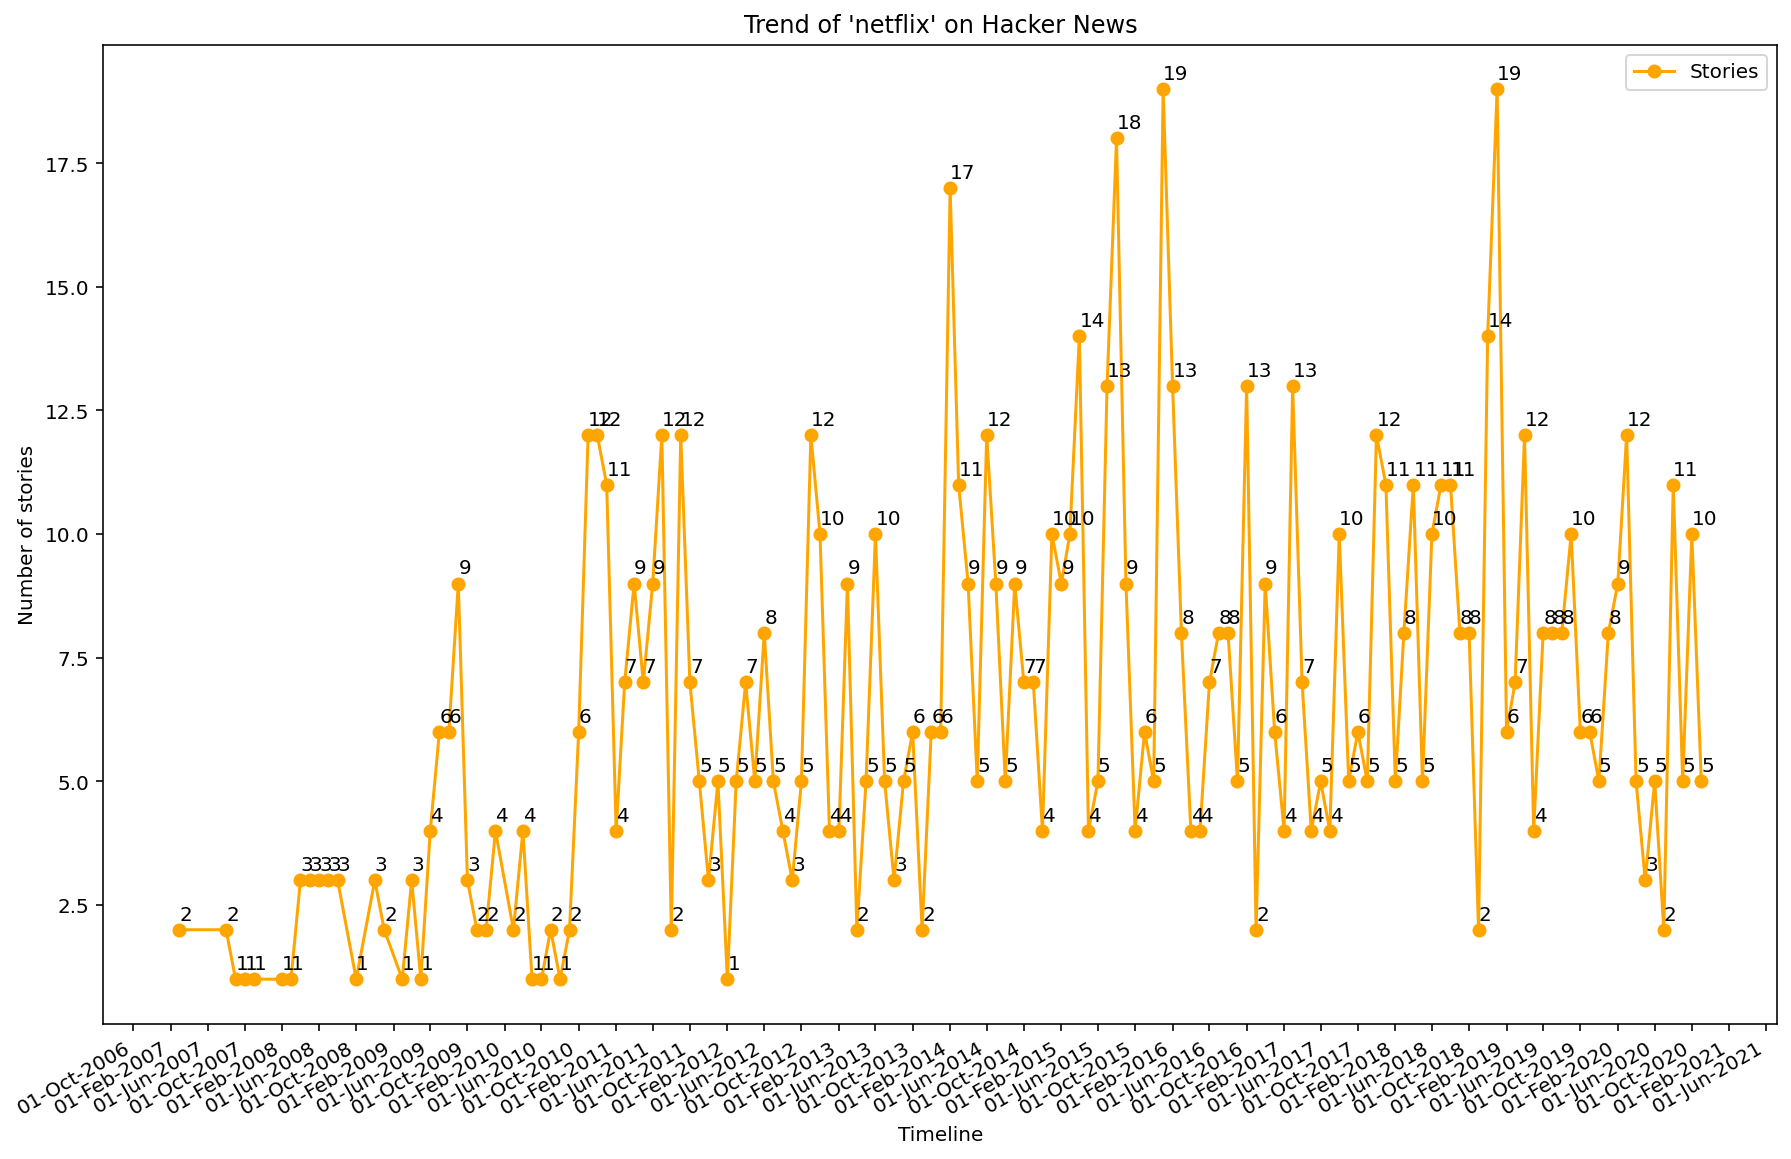

In [49]:
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(1,1,1)

ax.plot(x,y, label='Stories', marker='o', color='orange')

# x-axis timeline formatting
# fig.autofmt_xdate()
# plt.xticks(rotation=45)

# xfmt = md.DateFormatter('%d-%b-%Y')
# ax.xaxis.set_major_formatter(xfmt)

plt.gca().xaxis.set_major_locator(md.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(md.DateFormatter("%d-%b-%Y"))
plt.gcf().autofmt_xdate()


# Labels
ax.set_title(f"Trend of '{keyword}' on Hacker News")
ax.set_xlabel('Timeline')
ax.set_ylabel('Number of stories')

ax.legend(loc='best')

# Labeling markers
for a, b in zip(x,y):
    ax.annotate(b, xy=(a,b), xytext=(0,5), textcoords='offset points')

<div class="alert alert-block alert-success">
<b>Success!</b> 
    
</div>

---
# References

Hacker News API documentation:
https://github.com/HackerNews/API

Algolia API documentation:
https://hn.algolia.com/api

**Class notebooks:**
- 16 - File I/O
- 19 - APIs
- graphing-with-matplotlib